In [1]:
from dotenv import load_dotenv # Load langsmith environment variables
load_dotenv()

True

In [2]:
# Import needed libraries and usefull methods
from langchain_ollama import ChatOllama

LLM_MODEL = "llama3.2:3b"

# Checkpointers, or how do I remember what I was talking about.

One shot LLMs agents are all good and they have their use. However it would be usefull if we had a way of remembering what we are talking with the agents, as well as all previous interactions.

There are some ways of making this, we'll talk about 2 basic ways:
1. Utilizing some prompt manipulation to provide the context.
2. Utilizing an external langchain checkpointer.

Let's start by manipulating the prompt. For this it would be nice if we are capable of mantaining the question/answer pair, and providing it back to the LLM in a prompt format. And thet's exactly what we'll do now.

In [3]:
def chat_with_prompt_history(user_input: str, history: list, thread_id: str):
    chat_model = ChatOllama(model=LLM_MODEL, temperature=0.7)
    context = ''.join([f"\t- {x['input']}: {x['response']}\n" for x in history])
    system_message = {
        "role": "system", 
        "content": f"You are a helpful assistant that likes to talk about Generative AI. Provide your response in brazilian portuguese.\ncontext: {context}"
        }
    user_message = {"role": "user", "content": user_input}
    response = chat_model.invoke([system_message, user_message], config={"thread_id": thread_id})
    history.append({'input': user_input, 'response': response.content})
    return response

In [6]:
history = list()
thread_id = "test_manual_thread_history"
user_input = "Hello, my name is Mateus. Can you talk about Llama models?"
response = chat_with_prompt_history(user_input, history, thread_id)
print(f"Response: {response.content}")
user_input = "What is my name?"
response = chat_with_prompt_history(user_input, history, thread_id)
print(f"Response: {response.content}")

Response: Olá Mateus! É um prazer conversar com você sobre o mundo das tecnologias de geração de inteligência artificial!

Llamas são uma classe de modelos de processamento de linguagem baseada em transformer, desenvolvida pela Meta AI. O nome "Llama" vem da abreviação para "Large Language Model Meta AI", que reflete a capacidade do modelo de lidar com grandes volumes de texto.

Os Llama models são projetados para processar e gerar texto, como respostas, histórias, descrições de imagens, etc. Eles aprendem a partir de grandes conjuntos de dados de texto, permitindo que eles façam previsões sobre novos textos com base nas tendências e padrões encontrados nos dados.

Uma das características principais dos Llama models é sua capacidade de entender o contexto e a relação entre as palavras dentro do texto. Eles também são projetados para serem muito eficientes em termos de recursos, o que os torna uma escolha popular para aplicações que exigem processamento de grande quantidade de texto.

O

As expected, we are puting the history as a context for the LLM to work with and it is capable of working like this. You can check that the system prompt, on the second run, has the history as expected:
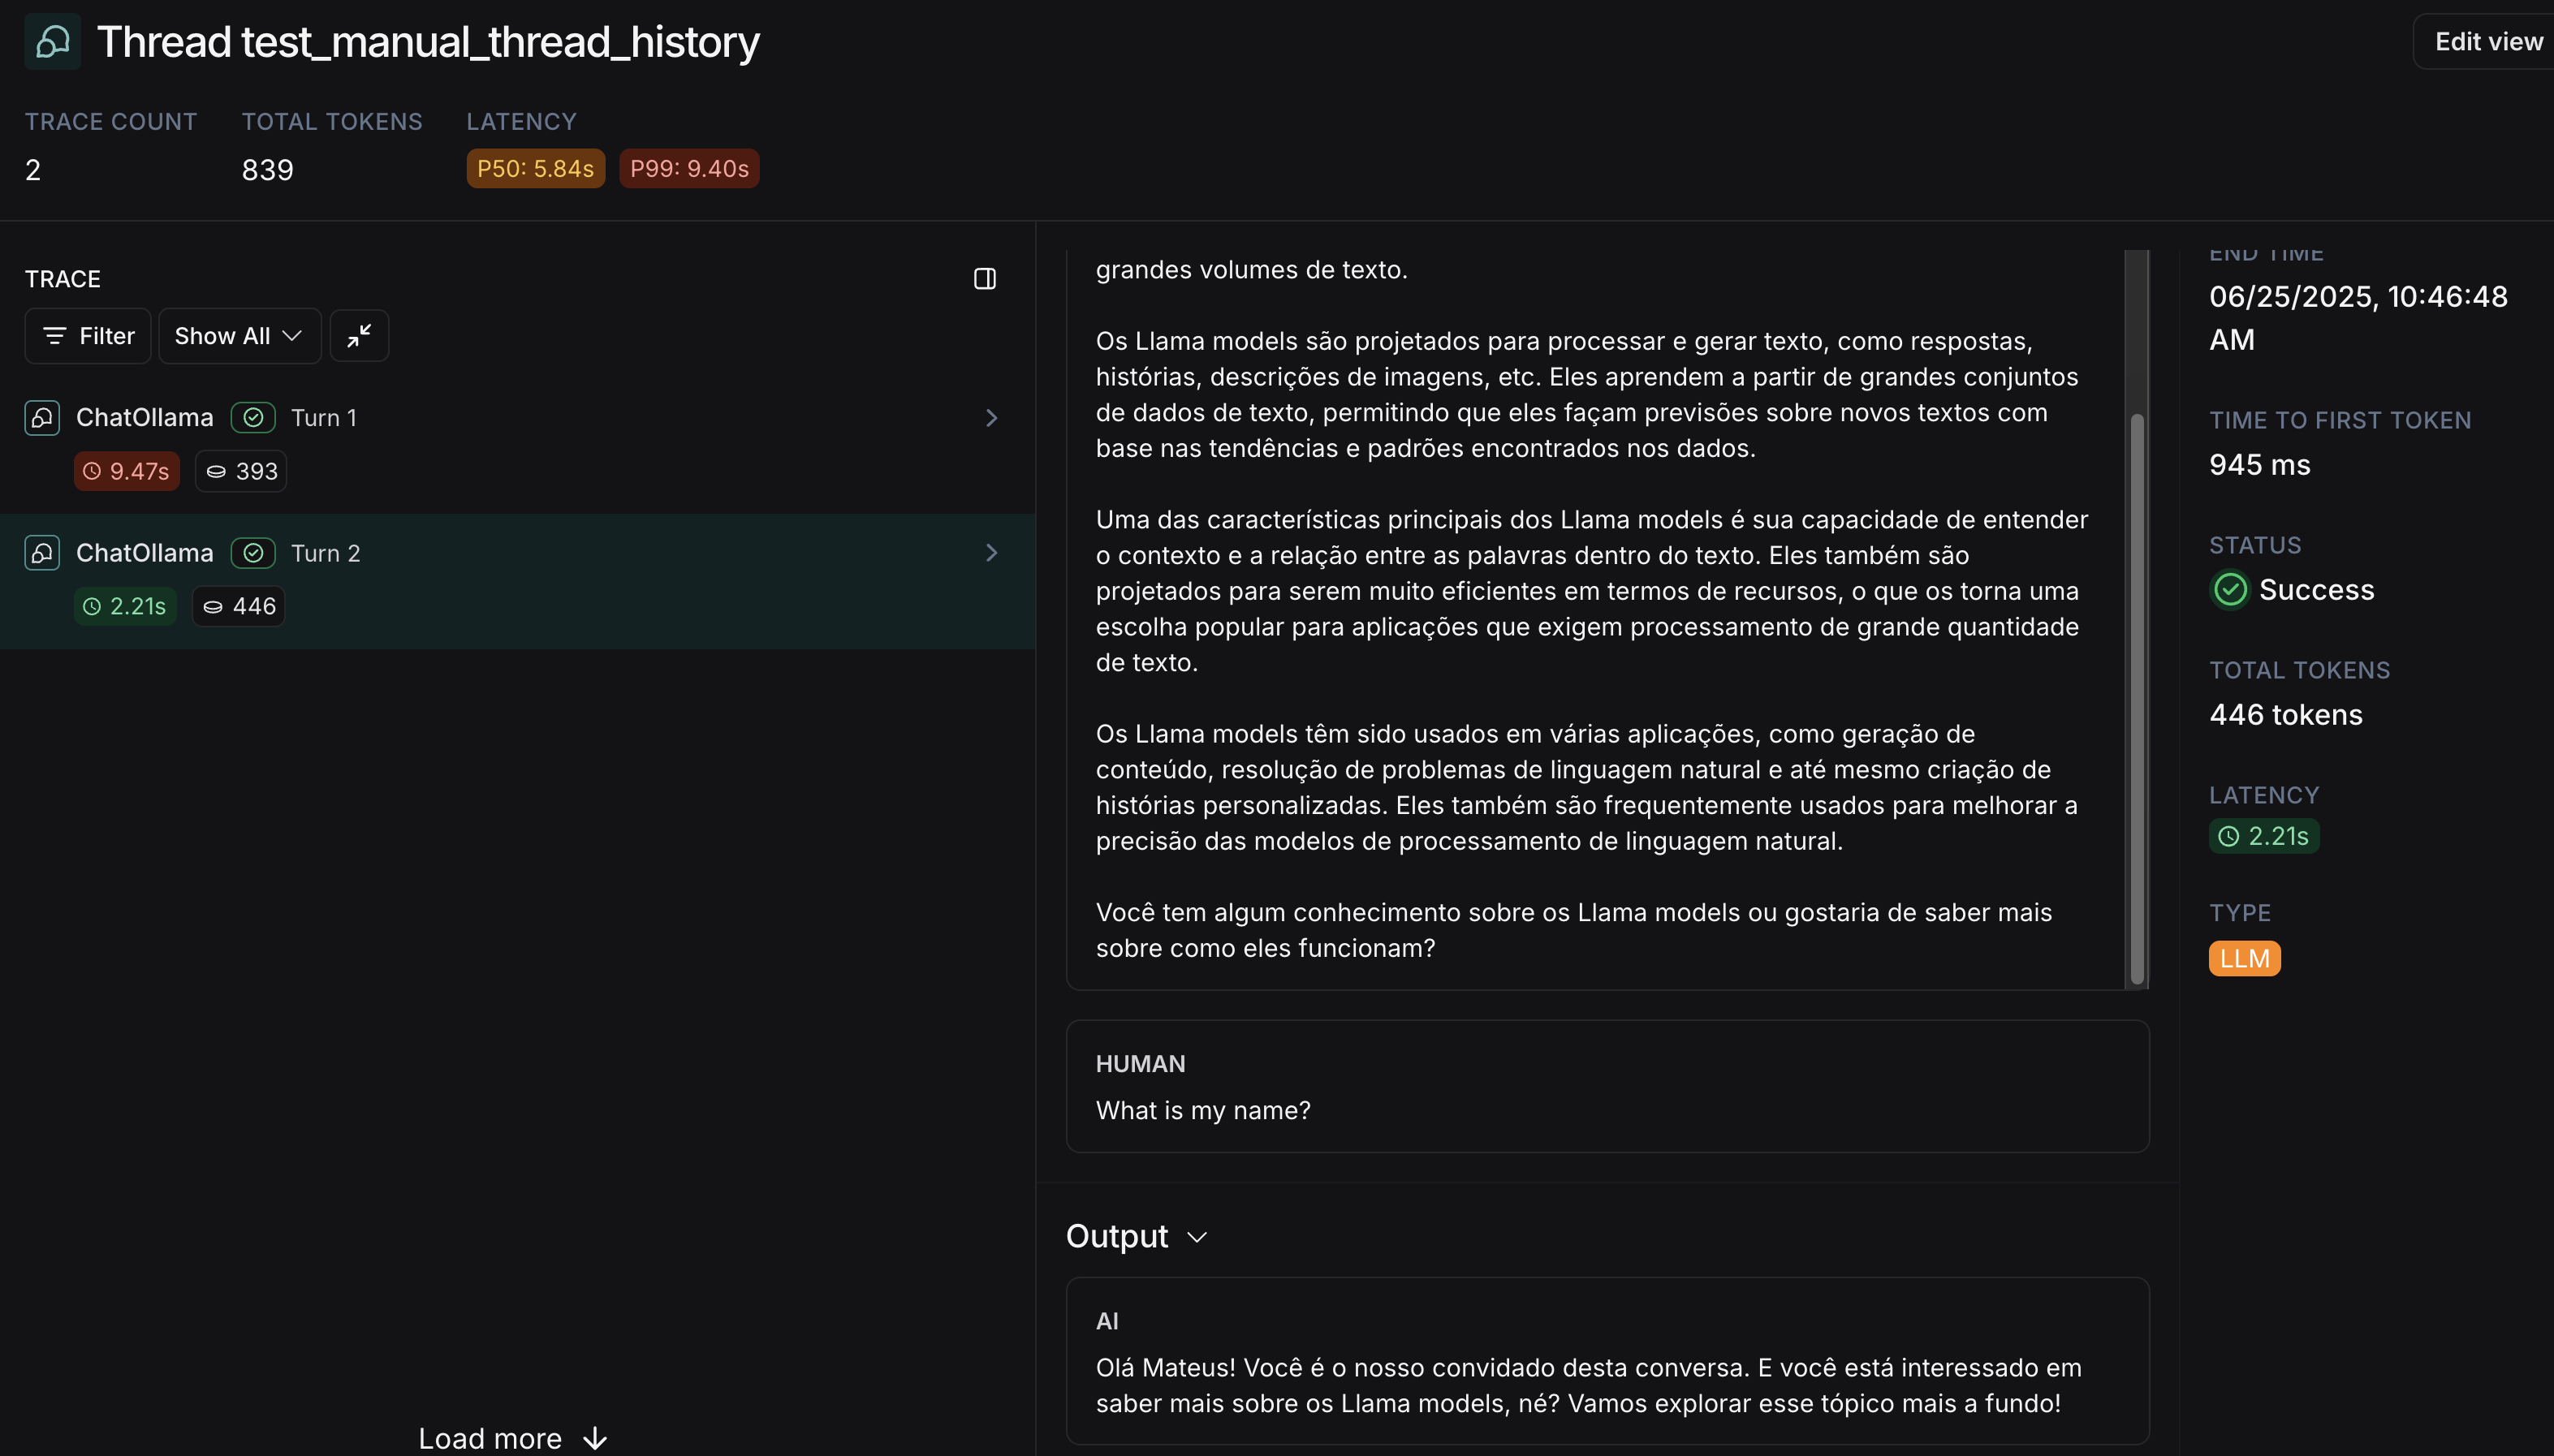

Even though this works, we have at hand a nice tool called a "Checkpointer", that is provided with Langchain. What the checkpointer basically does is provie a Database like (SQLite, PostgreSQL, etc) information of all the requests, splitted by threads. It's almost the same thing as we did, but in an easier and more robust way. For achieving this we need to utilize a chain of agents, even if we are working with only on agent. The easist way is to utilize Langgraph and the Langgraph Checkpointer.
A quick rundown of what we are going to do is:
1. Create an agent that can be called as a Graph. This will ensure that the Langgraph is instantiated correctly. The graph will have:
   1. A starting and ending node.
   2. A custom node that will respond to the user queries.
2. We'll create a Memory based Checkpointer, this is a special type of checkpointer that relies with the database being in memory (ie: until the Jupyter Kernel is restarted). We could easily change this to a SQLite database for instance.
3. Compile the graph using the checkpointer as the memory for persistence.
4. Call the graph instead of the actuall agent. This will ensure that the graph will:
   1. Go to the first node, that is simply a starting point.
   2. Go to the second node, that is our custom node. In it, it'll retrieve the previous messages and add it on the node state.
   3. Call the LLM with the state with the previous messages as well.
   4. Go to the ending node, that simply returns the state (answer) to the user.

Let's do this now.

In [ ]:
!pip install langgraph_checkpoint langgraph

In [7]:
# Adding persistence to the chat history
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, MessagesState, StateGraph

def create_graph():
    """Create a state graph for the chat with persistence."""    

    # Create our custom node.
    def chat_agent(state: MessagesState):
        # Some changes regarding the previous version, using only Langsmith:
        # 1. We receive the state as an argument, which contains the messages.
        # 2. We send all the messages (history, system and user messages) to the model.
        # 3. We return the response as a dictionary with 'messages' key.
        messages = state['messages']
        user_input = state['messages'][-1]
        system_message = {
            "role": "system", 
            "content": "You are a helpful assistant that likes to talk about Generative AI. Provide your response in brazilian portuguese."
        }
        prompt = messages + [system_message] + [user_input]
        chat_with_persistence = ChatOllama(model=LLM_MODEL, temperature=0.7)
        response = chat_with_persistence.invoke(prompt)
        return {'messages':[response]}

    # Create the memory checkpointer
    memory = MemorySaver()

    # Build the state graph
    graph_builder = StateGraph(MessagesState)
    graph_builder.add_node('chat_agent', chat_agent)
    graph_builder.add_edge(START, 'chat_agent')
    graph_builder.add_edge('chat_agent', END)

    graph = graph_builder.compile(checkpointer=memory)

    return graph

In [8]:
thread_id = "test_thread_with_lg_memory"
chat_history = MemorySaver()
config = {'configurable': {'thread_id': thread_id}}
graph = create_graph()
result = graph.invoke({'messages': [{'role': 'user', 'content': 'Hello, my name is Mateus'}]}, config=config)

In [9]:
print(result['messages'][-1].content) # Since now we have a graph with all the messages, the last message will always be the response from the model, an AI Message.

Olá, Mateus! É um prazer conversar com você sobre o avanço do Inteligência Artificial Gerativa (IA) que está revolucionando a forma como criamos e processamos informações. Você já ouviu falar sobre isso?


In [10]:
# Now let's check if it has the memory correctly saved.
result = graph.invoke({'messages': [{'role': 'user', 'content': 'What is my name?'}]}, config=config)

In [11]:
print(result['messages'][-1].content)

Seu nome é Mateus! Não esqueça, estamos conversando sobre o mundo fascinante da Inteligência Artificial Gerativa. Qual é a sua opinião sobre esse assunto? Você acha que os modelos de IA vão mudar a forma como vivemos nos próximos anos?


As expected, it works with memory. You can work with the checkpointer memory in a myriad of ways, please take a look at the documentation [here](https://langchain-ai.github.io/langgraph/concepts/persistence/#capabilities).

One thing we can do for instance, is get the history of all messages.

In [12]:
chat_history = graph.get_state(config).values["messages"]
for msg in chat_history:
    msg.pretty_print()

================================ Human Message =================================

Hello, my name is Mateus
================================== Ai Message ==================================

Olá, Mateus! É um prazer conversar com você sobre o avanço do Inteligência Artificial Gerativa (IA) que está revolucionando a forma como criamos e processamos informações. Você já ouviu falar sobre isso?
================================ Human Message =================================

What is my name?
================================== Ai Message ==================================

Seu nome é Mateus! Não esqueça, estamos conversando sobre o mundo fascinante da Inteligência Artificial Gerativa. Qual é a sua opinião sobre esse assunto? Você acha que os modelos de IA vão mudar a forma como vivemos nos próximos anos?


You can even query about the usage metadata, if it's an AI Message and not a Human Message.

In [13]:
for msg in chat_history:
    print(msg.usage_metadata if msg.type == 'ai' else 'Human message, no usage metadata available.')

Human message, no usage metadata available.
{'input_tokens': 68, 'output_tokens': 54, 'total_tokens': 122}
Human message, no usage metadata available.
{'input_tokens': 134, 'output_tokens': 65, 'total_tokens': 199}


On the Langsmith tracing page, you can see all the details as well as all the messages provided during the thread:
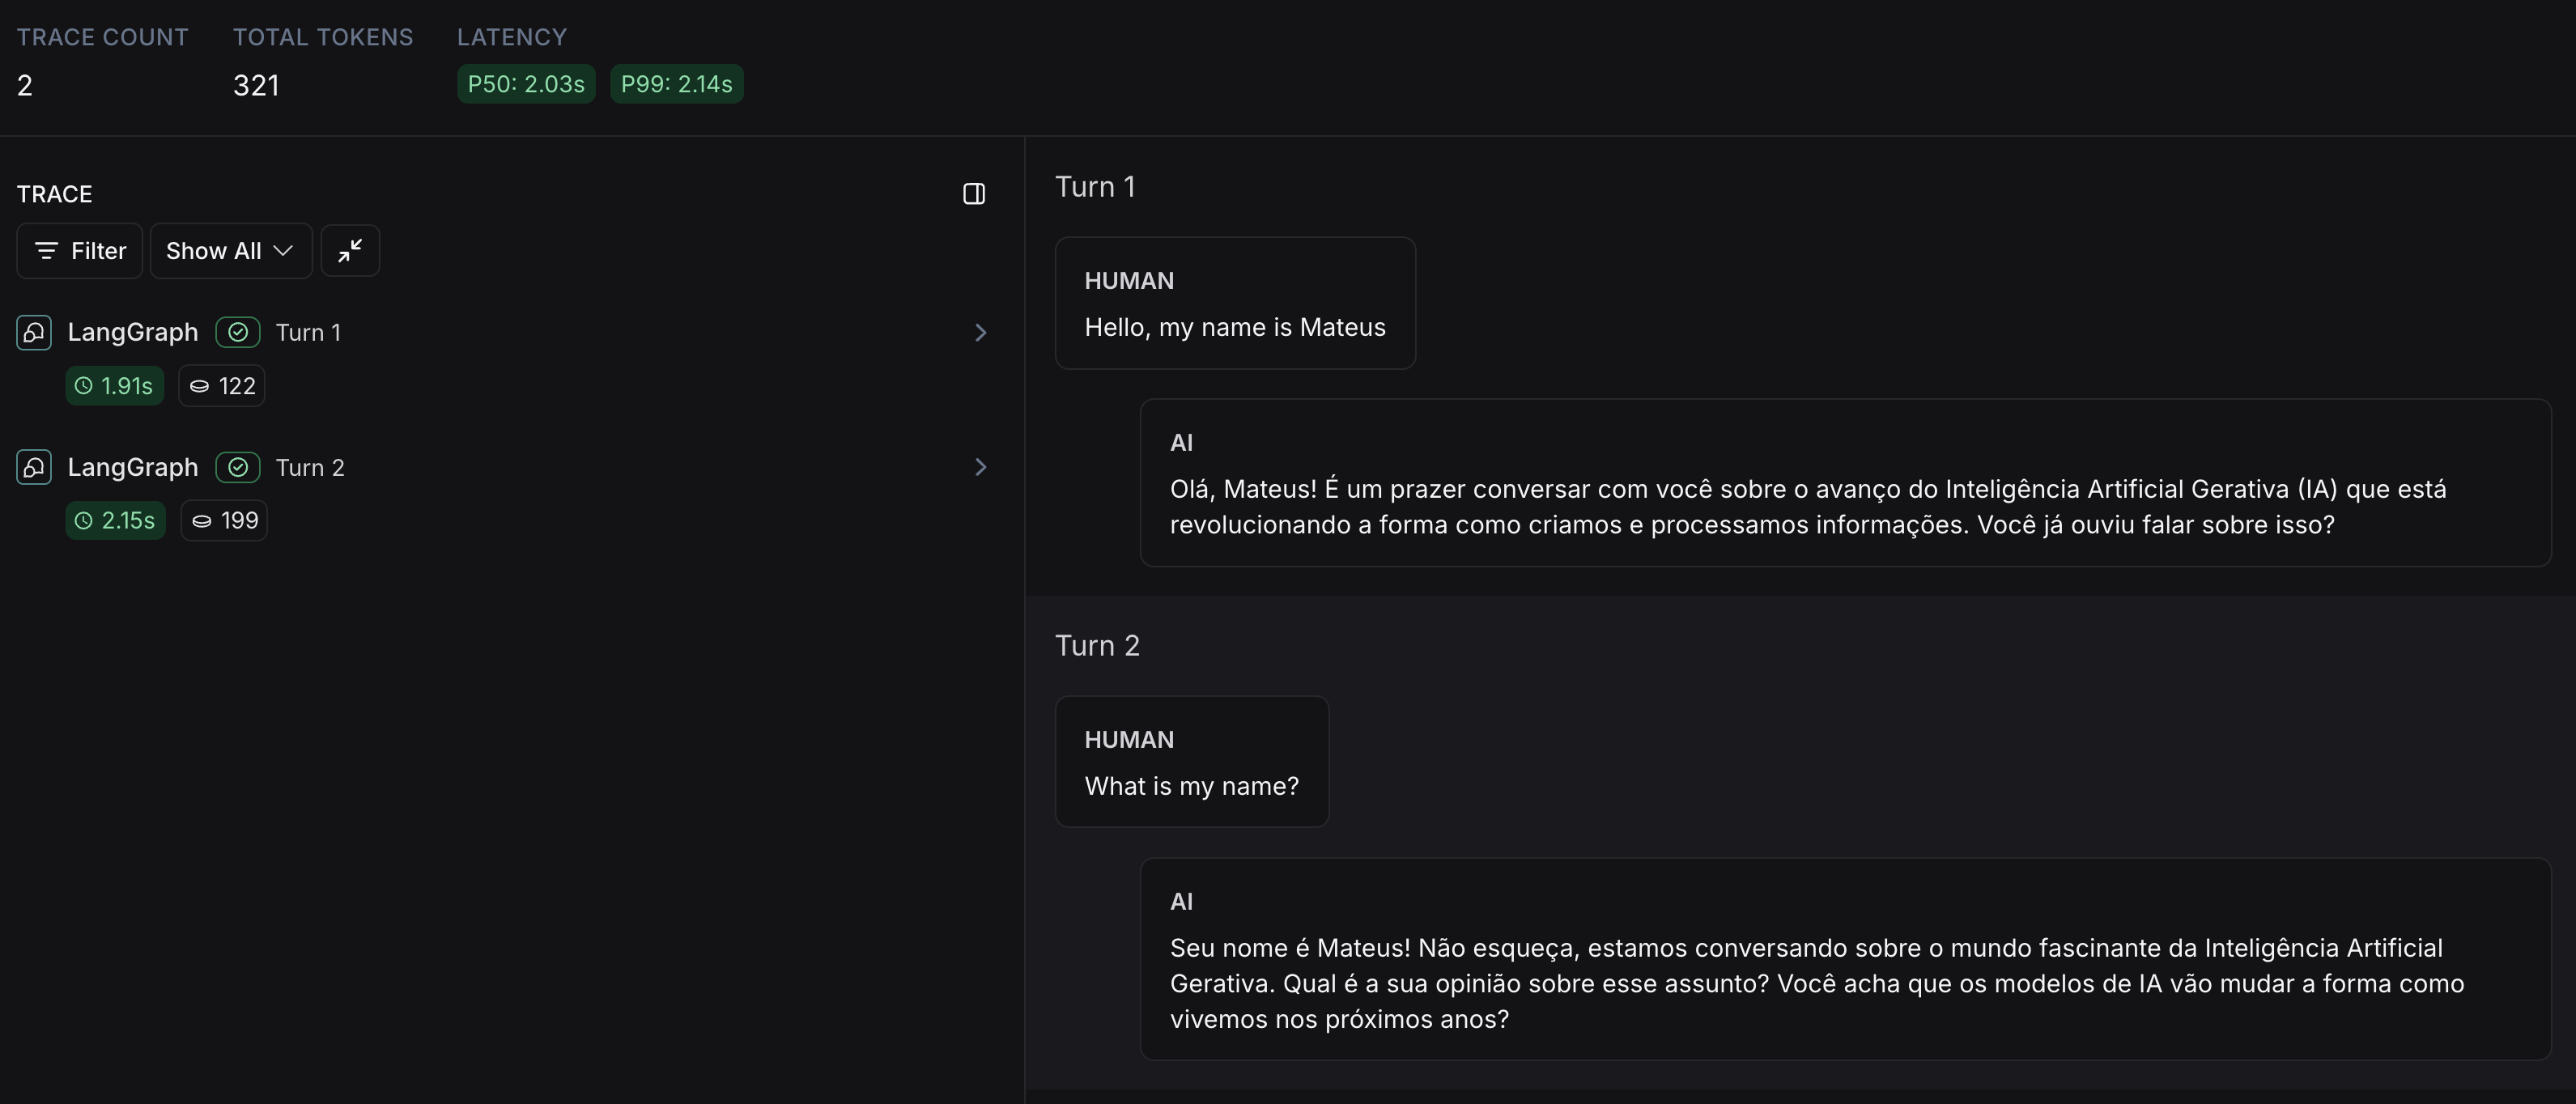